<a href="https://colab.research.google.com/github/HakureiPOI/computer-vision-2025/blob/main/Homework4/homework4_remodify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 220110720 HakureiPOI

In [1]:
!git clone https://github.com/HakureiPOI/computer-vision-2025.git

Cloning into 'computer-vision-2025'...
remote: Enumerating objects: 986, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 986 (delta 97), reused 106 (delta 36), pack-reused 773 (from 2)
Receiving objects: 100% (986/986), 35.78 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (178/178), done.


In [2]:
%cd /content/computer-vision-2025/Homework4

/content/computer-vision-2025/Homework4


In [3]:
!git pull

Already up to date.


# Homework 4

We have learned about the basics of using machine learning and deep learning for many computer vision problems. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

First of all, you may want to do `conda install pytorch torchvision -c pytorch` in your virtual environment to install PyTorch.

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`.

As a quick refresher question. Why do we want to split our data into training and testing sets? (5 points)

**You answer here:** Write your answer in this markdown cell.



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os
# set random seeds
torch.manual_seed(2023)
np.random.seed(2023)
random.seed(2023)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10, so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

Why do we want to normalize the images beforehand? (5 points)

*HINT*: consider the fact that the network we developed will be deployed to a large number of images.

**You answer here:** Write your answer in this markdown cell.



In [5]:
from torch.utils.data import DataLoader

trainloader = None
testloader = None
batch_size = 256

# 设置 transform
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# 加载 CIFAR-10 数据集
trainset = torchvision.datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform
)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# these are the 10 classes we have in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# running this block will take a few minutes to download the dataset if you haven't done so

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


In [6]:
len(trainloader), len(testloader), trainset[0][0].shape

(196, 100, torch.Size([3, 32, 32]))

Let's plot out some training images to see what we are dealing with:

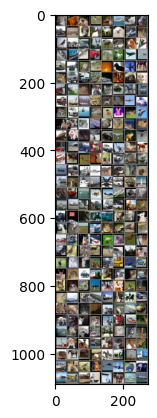

  cat   cat  frog  bird  deer  ship   cat  bird truck truck  bird horse horse   dog   car  bird  bird plane plane  deer horse   car   dog plane  deer  ship plane   car horse   dog plane  deer  ship  ship   cat  frog plane   cat plane horse   cat   car truck  frog   car   dog   cat   dog truck  ship   dog   dog   cat   car horse   car truck  ship  ship  frog  deer  bird plane   car  frog   car  ship   cat  bird   cat  deer  bird   dog horse   cat  ship  bird  frog  ship   dog plane   dog  bird  deer   car plane  frog   cat   car plane   car   dog   car  bird   dog horse truck   dog  bird   cat  bird   car   cat  frog  ship truck  ship  ship horse   dog   cat   dog  ship   dog  ship  ship plane   car  frog  ship   dog   car  ship   cat plane  ship   car   cat  ship plane truck truck truck   car truck  frog truck   car   cat truck   car horse   cat   dog horse   dog  deer  ship  frog  frog  frog  deer  ship   car   cat  ship  frog   cat horse   cat   car  bird   dog  deer  deer   car  bir

In [7]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)     # Python 的标准迭代器是用内置的 next() 方法啊

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `network.py`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output. (15 points)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 6, kernel_size=5),
#             nn.BatchNorm2d(6),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(6, 16, kernel_size=5),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(8*8*128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
# from network import Net
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [12]:
torch.cuda.is_available(), torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else 'No cuda'

(True, 'Tesla T4')

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start).

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [13]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take just several minutes on your device(CPU or GPU).

The last step of training is to save the trained model locally to a checkpoint:

In [14]:
train = False

epoch_num = 50 if train else 0
# print_interval = 300

for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        pred = net(inputs)
        optimizer.zero_grad()

        loss = criterion(pred, labels)
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()

        correct += (torch.argmax(pred, dim=1) == labels).sum().item()
        total += len(labels)

        # if (i+1) % print_interval == 0:
        #     print('[%d, %5d] loss: %.3f, acc: %.3f' %
        #           (epoch + 1, i + 1, running_loss / print_interval, correct / total))

        #     running_loss = 0.0
        #     correct = 0
        #     total = 0

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss / len(trainloader), correct / total))

    scheduler.step()

print('Finished Training')

Finished Training


In [15]:
PATH = './cifar_net.pth'

if train:
    torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

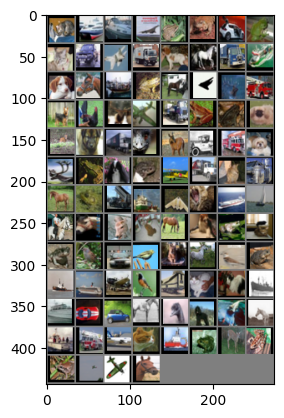

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse


In [16]:
testiter = iter(testloader)
images, labels = next(testiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(100)))

Now, let's load in our saved model checkpoint and get its output:

In [17]:
PATH = 'cifar_net_79.pth'

In [18]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [19]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []

with torch.no_grad():
    images=images.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(100)))

Predicted:    cat  ship  ship plane  frog  frog   car  deer   cat   car plane truck   dog horse truck  frog   dog horse  ship  frog horse plane  deer truck  deer  bird  deer plane truck  frog  frog   dog  bird   dog truck  ship  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse   dog   cat horse   dog  frog   cat  frog  bird   car  bird   cat plane  bird  frog  ship  ship plane  bird truck   cat   dog  ship  ship   car   car horse  bird horse  bird horse  ship truck plane  frog  ship  frog  deer  frog  frog plane plane horse


How does your prediction look like? Does that match your expectation? Write a few sentences to describe what you got and provide some analysis if you have any. (5 points)

**You answer here:** Write your answer in this markdown cell.



Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)

        total += len(outputs)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better? (5 points)

**You answer here:** Write your answer in this markdown cell.



Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [21]:
# prepare to count predictions for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)

        total += len(outputs)
        predicted = torch.argmax(outputs, dim=1)
        correct = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print accuracy for each class
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 89 %
Accuracy of  bird : 70 %
Accuracy of   cat : 62 %
Accuracy of  deer : 77 %
Accuracy of   dog : 71 %
Accuracy of  frog : 89 %
Accuracy of horse : 81 %
Accuracy of  ship : 87 %
Accuracy of truck : 85 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance as much as possible. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not? (15 points)

**You answer here:** Write your answer in this markdown cell.

